# Mortality Rates in the Netherlands

> Last updated April 5, 2020

Source data:
- [Weekly mortatlity figures](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=70895ned&_theme=75)
- [Montly population figures](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=37943ned&_theme=62)

Entry for mortality week 13 2020 added manually based on latest reports, which was not reflected in source data at time of writing ([see here](https://www.cbs.nl/en-gb/faq/corona/medisch/how-many-deaths-are-registered-per-week-)).



In [1]:
import pandas as pd

In [2]:
deceased = pd.read_csv(
    'deceaseddata20200405.csv',
    sep=';',
    names=['id', 'sex', 'age', 'per', 'd'],
    skiprows=1,  # skip header
    dtype={'id':int,'sex':int,'age':int,'per':str,'d':int}
)

In [3]:
period_filters = (
    ~deceased.per.str.contains('X0') &  # remove incomplete first weeks of year
    ~deceased.per.str.contains('W101') &  # remove first weeks of year that could start in prev year
    ~deceased.per.str.contains('W152') &  # remove incomplete last week of year
    ~deceased.per.str.contains('W153') &  # remove incomplete last week of year (in 2011)
    ~deceased.per.str.contains('JJ')  # remove full year data contained in series
)

In [4]:
deceased = deceased[period_filters]

In [5]:
deceased['dt'] = pd.to_datetime(deceased.per + str(1), format='%GW1%V%u')

In [6]:
# confirm the only date format that remains is in W-format (weeks)
sum(deceased.per.str.contains('W')) == len(deceased.per.str.contains('W'))

True

In [7]:
# confirm that the inferred year matches the year in the period column
[int(year) for year in deceased.per.str[:4].tolist()] == pd.DatetimeIndex(deceased['dt']).year.tolist()

True

In [8]:
# keep only broad demographics (all genders and ages)
all_genders = deceased['sex']==1100
all_ages = deceased['age']==10000

demo_filters = all_genders & all_ages

In [9]:
deceased = deceased[demo_filters]

In [10]:
# cleanup columns
deceased = deceased.drop(['id','sex','age','per'], axis=1)

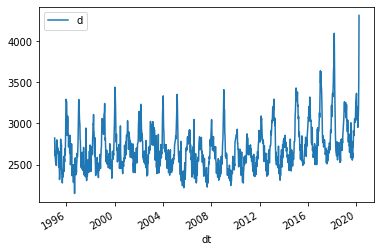

In [11]:
# quick plot show no spikes other than expected yearly seasonality
deceased.plot(x='dt')

In [12]:
pop = pd.read_csv(
    'populationdata20200405.csv',
    sep=';',
    usecols=[1, 2],
    names=['per', 'pop'],
    skiprows=1,  # skip header
    dtype={'per':str,'pop':int}
)

In [13]:
year_filters = (
    ~pop.per.str.contains('JJ')  # remove full year from series
)

In [14]:
pop = pop[year_filters]

In [15]:
pop['dt'] = pd.to_datetime(pop.per, format='%YMM%m')

In [16]:
pop = pop.drop('per', axis=1)

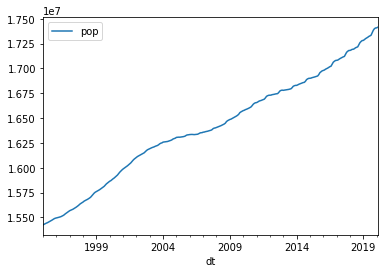

In [17]:
# quick plot to confirm data - population grew from roughly 15 to >17 million in time period
pop.plot(x='dt')

In [18]:
pop.head()

,pop,dt
0,15424122,1995-01-01
1,15430178,1995-02-01
2,15436176,1995-03-01
3,15441920,1995-04-01
4,15446212,1995-05-01


In [19]:
# merge on month grouper (population data is not available at weekly granularity)
merged = pd.merge(
    deceased.assign(grouper=deceased['dt'].dt.to_period('M')),
    pop.assign(grouper=pop['dt'].dt.to_period('M')),
    how='left',
    on='grouper'
)

In [20]:
# cleanup columns
merged = merged.drop(['grouper', 'dt_y'], axis=1).fillna(method='ffill')

In [21]:
# compute mortality rate (typically reported as deaths per 1000)
merged['mrate'] = merged['d'] / merged['pop'] * 1000

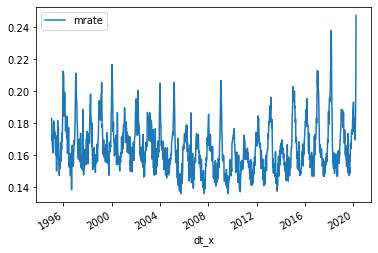

In [22]:
# quick plot to confirm data is properly scaled
merged.plot(x='dt_x', y='mrate')

In [23]:
# create week and year columns for plot data
merged['week'] = merged.dt_x.dt.week
merged['year'] = merged.dt_x.dt.year

In [24]:
plotdata = merged.pivot(index='week',columns='year',values='mrate')

In [25]:
# convert to string headers as integers break pandas/bokeh
plotdata.columns = [str(header) for header in plotdata.columns.tolist()]

In [26]:
plotdata['mn'] = plotdata.iloc[:,:-1].mean(axis=1)  # calculate means for 1995-2019

In [27]:
plotdata['s'] = plotdata.iloc[:,:-2].std(axis=1)  # calculate standard deviations for 1995-2019

In [28]:
plotdata['upper'] = plotdata['mn'] + 2 * plotdata['s']  # upper 2-sigma CI level

In [29]:
plotdata['lower'] = plotdata['mn'] - 2 * plotdata['s']  # lower 2-sigma CI level

In [30]:
plotdata = plotdata.drop('s', axis=1)  # remove standard deviation from plotdata

In [31]:
# sanity check
plotdata.head()

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2014,2015,2016,2017,2018,2019,2020,mn,upper,lower
week,,,,,,,,,,,,,,,,,,,,,
2,0.183025,0.210212,0.211343,0.163407,0.190670,0.216718,0.178394,0.195278,0.184467,0.205006,...,0.167506,0.202891,0.181105,0.212920,0.195506,0.188750,0.193238,0.186950,0.219111,0.154789
3,0.169151,0.191688,0.208709,0.154463,0.185150,0.208460,0.181834,0.188261,0.184097,0.187907,...,0.162811,0.199814,0.180339,0.204139,0.195797,0.182269,0.181003,0.182160,0.213713,0.150607
4,0.172716,0.184266,0.204598,0.161618,0.181850,0.201904,0.189591,0.191179,0.182985,0.179665,...,0.161029,0.198394,0.188526,0.212276,0.193352,0.183889,0.174627,0.181485,0.211036,0.151934
5,0.167076,0.193108,0.196633,0.171903,0.188499,0.187028,0.183148,0.182425,0.174216,0.178804,...,0.160910,0.196560,0.182705,0.209232,0.198067,0.181864,0.181347,0.180930,0.206025,0.155834
6,0.164353,0.199325,0.193424,0.166948,0.196934,0.178643,0.178867,0.177435,0.169468,0.169195,...,0.169598,0.193578,0.178760,0.201712,0.204417,0.184209,0.183005,0.180184,0.206268,0.154100


In [32]:
from bokeh.plotting import figure, output_file, save
from bokeh.models import Span, Label, Title

In [ ]:
output_file('mortality.html', title='Mortality Rate in the Netherlands')

cols=len(plotdata.columns)

fig = figure(
    tools='pan,wheel_zoom,box_zoom,save,reset',
    x_axis_label='Week Number',
    x_minor_ticks=10,
    x_range=[1,52],
    y_axis_label='Mortality Rate (per 1000 citizens)',
    plot_width=1000,
    plot_height=600,
    toolbar_location='above'
)

fig.title.text = 'Weekly Mortality Rate in the Netherlands 1995-2020'
fig.title.align = 'center'
fig.title.text_font_size = '25px'

first_case = Span(
    location=9,
    dimension='height',
    line_color='red',
    line_dash='dashed',
    line_width=1.5,
    line_alpha=0.5
)

fig.add_layout(first_case)

fig.add_layout(
    Title(
        text='Source: Statistics Netherlands (2020). Preliminary data for 2019 and 2020.', 
        align='left',
        text_font_size='12px'
    ),
    'below'
)

case_label = Label(
    x=2.3,
    y=0.241,
    text='First reported case',
    render_mode='css',
    text_font_size='14px'
)

fig.add_layout(case_label)

for i in range(cols-6):  # add all historic years
    fig.line(
        x=plotdata.index,
        y=plotdata.iloc[:,i],
        line_color='grey',
        line_alpha=0.15,
        line_width=1
    )

fig.line(
    x=plotdata.index,
    y=plotdata['2019'],
    line_color='grey',
    line_alpha=0.15,
    line_width=1
)


fig.line(
    x=plotdata.index,
    y=plotdata.mn,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    legend_label='Average (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.upper,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted',
    legend_label='95% CI (1995-2019)'
)

fig.line(
    x=plotdata.index,
    y=plotdata.lower,
    line_color='black',
    line_alpha=0.5,
    line_width=1.5,
    line_dash='dotted'
)


fig.line(
    x=plotdata.index,
    y=plotdata['2018'],
    line_color='blue',
    line_alpha=1,
    line_width=1.5,
    legend_label='2018 (influenza epidemic)'
)

fig.line(
    x=plotdata.index,
    y=plotdata['2020'],
    line_color='red',
    line_alpha=1,
    line_width=3,
    legend_label='2020 (COVID-19 outbreak)'
)

save(fig)